In [7]:
import time
import numpy as np
import tensorflow as tf
import pickle
from dataSet import ReadFromTFRecord, DataBatch, ImgShow # data processing
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from skimage.transform import resize

In [8]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)
 
# calculate the inception score for p(y|x)
def calculate_inception_score(p_yx, eps=1E-16):
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # kl divergence for each image
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    # undo the logs
    is_score = exp(avg_kl_d)
    return is_score

# the preprocessing of batch
def batch_preprocess(data_batch):
    # get the data
    batch = sess.run(data_batch)
    #RGB（Nx32x32x3）
    batch_images = np.reshape(batch, [-1, 3, 32, 32]).transpose((0, 2, 3, 1))
    # scale to -1, 1
    batch_images = batch_images * 2 - 1
    return  batch_images

# generate the folder for saving the model and training info
def Dir():
    import os
    if not os.path.isdir('ckpt'):
        print('No ckpt folder found, now generating...')
        os.mkdir('ckpt')
    if not os.path.isdir('trainLog'):
        print('No trainLog folder found, now generating...')
        os.mkdir('trainLog')

# Parameters

In [9]:
real_shape = [-1,32,32,3] # the size of samples
data_total = 5000 # the number of samples
batch_size = 64 
noise_size = 128 
max_iters = 12000 # maximum number of iterations
learning_rate = 0.0002 
smooth = 0.1 # smooth parameter of label, label*(1 - smooth)
beta1 = 0.4 # ADAM parameter
CRITIC_NUM = 1 # the discriminator will be trained every interation

# Define networks

In [10]:
# define the generator
def GeNet(z, channel, is_train=True):
    """
    :param z: noise，tensor
    :param channnel: the channel number of the generated images
    :param is_train: for "batch_normalization", true when trainging
    """

    with tf.variable_scope("generator", reuse=(not is_train)):
        # layer1: noise_dim --> 4*4*512 --> 4x4x512 -->BN+relu
        layer1 = tf.layers.dense(z, 4 * 4 * 512)
        layer1 = tf.reshape(layer1, [-1, 4, 4, 512])
        layer1 = tf.layers.batch_normalization(layer1, training=is_train,)
        layer1 = tf.nn.relu(layer1)
        # layer1 = tf.nn.dropout(layer1, keep_prob=0.8)# dropout

        # layer2: deconv(ks=3x3,s=2,padding=same):4x4x512 --> 8x8x256 --> BN+relu
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 3, strides=2, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                            bias_initializer=tf.random_normal_initializer(0, 0.02))
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.nn.relu(layer2)
        # layer2 = tf.nn.dropout(layer2, keep_prob=0.8)# dropout

        # layer3: deconv(ks=3x3,s=2,padding=same):8x8x256 --> 16x16x128 --> BN+relu
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 3, strides=2, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                            bias_initializer=tf.random_normal_initializer(0, 0.02))
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.nn.relu(layer3)
        # layer3 = tf.nn.dropout(layer3, keep_prob=0.8)# dropout

        # layer4: deconv(ks=3x3,s=2,padding=same):16x16x128 --> 32x32x64--> BN+relu
        layer4 = tf.layers.conv2d_transpose(layer3, 64, 3, strides=2, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                            bias_initializer=tf.random_normal_initializer(0, 0.02))
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        layer4 = tf.nn.relu(layer4)
        # layer4 = tf.nn.dropout(layer3, keep_prob=0.8)# dropout

        # logits: deconv(ks=3x3,s=2,padding=same):32x32x64 --> 32x32x3
        logits = tf.layers.conv2d_transpose(layer4, channel, 3, strides=1, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(0, 0.02),
                                            bias_initializer=tf.random_normal_initializer(0, 0.02))
        # outputs
        outputs = tf.tanh(logits)

        return logits,outputs


# discriminator
def DiNet(inputs_img, reuse=False, GAN = False,GP= False,alpha=0.2):
    """
    @param inputs_img: input images，tensor
    @param reuse: reuse the discriminator
    @param GP: when using WGAN-GP, close BN
    @param alpha: for Leaky ReLU
    @param GAN: is WGAN or not
    """

    with tf.variable_scope("discriminator", reuse=reuse):
        
        # layer1: conv(ks=3x3,s=2,padding=same)+lrelu -->32x32x3 to 16x16x128
        layer1 = tf.layers.conv2d(inputs_img, 128, 3, strides=2, padding='same')
        if GP is False:
            layer1 = tf.layers.batch_normalization(layer1, training=True)
        layer1 = tf.nn.leaky_relu(layer1,alpha=alpha)
        # layer1 = tf.nn.dropout(layer1, keep_prob=0.8)

        # layer2: conv(ks=3x3,s=2,padding=same)+BN+lrelu -->16x16x128 to 8x8x256
        layer2 = tf.layers.conv2d(layer1, 256, 3, strides=2, padding='same')
        if GP is False:
            layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.nn.leaky_relu(layer2, alpha=alpha)
        # layer2 = tf.nn.dropout(layer2, keep_prob=0.8)

        # layer3: conv(ks=3x3,s=2,padding=same)+BN+lrelu -->8x8x256 to 4x4x512
        layer3 = tf.layers.conv2d(layer2, 512, 3, strides=2, padding='same')
        if GP is False:
            layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.nn.leaky_relu(layer3, alpha=alpha)
        layer3 = tf.reshape(layer3, [-1, 4*4* 512])
        # layer3 = tf.nn.dropout(layer2, keep_prob=0.8)

        # logits,output:
        logits = tf.layers.dense(layer3, 1)
 
        # no sigmoid for WGAN
        if GAN:
            outputs = None
        else:
            outputs = tf.sigmoid(logits)

        return logits, outputs

    
################################# inputs ####################################
inputs_real = tf.placeholder(tf.float32, [None, real_shape[1], real_shape[2], real_shape[3]], name='inputs_real') # real images input
inputs_noise = tf.placeholder(tf.float32, [None, noise_size], name='inputs_noise') # fake images input

################################# generator samples ####################################
_,g_outputs = GeNet(inputs_noise, real_shape[3], is_train=True) 
_,g_test = GeNet(inputs_noise, real_shape[3], is_train=False)

################################# discriminator samples ####################################
d_logits_real, _ = DiNet(inputs_real)
d_logits_fake, _ = DiNet(g_outputs, reuse=True)


################################# generator loss ####################################
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake) * (1 - smooth)))

################################# discriminator loss, real ####################################
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                     labels=tf.ones_like(d_logits_real) * (1 - smooth)))

################################# discriminator loss, fake ####################################
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))

################################# discriminator loss, intergration ####################################
d_loss = tf.add(d_loss_real, d_loss_fake)


train_vars = tf.trainable_variables()
g_vars = [var for var in train_vars if var.name.startswith("generator")]
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]


#optimizer
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars) 
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

################################# read TFRecord ####################################
[data,label] = ReadFromTFRecord(sameName= r'./TFR/class1-*',isShuffle= False,datatype= tf.float64,
                                labeltype= tf.int64,isMultithreading= True)
[data_batch,label_batch] = DataBatch(data,label,dataSize= 32*32*3,labelSize= 1,
                                                   isShuffle= True,batchSize= 64)


GenLog = []# training log
losses = []# loss log

# save the recent 5 models
saver = tf.train.Saver(var_list=[var for var in tf.trainable_variables()
                                 if var.name.startswith("generator")],max_to_keep=5)


ValueError: Variable generator/dense/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)


# Training

In [11]:
# session
with tf.Session() as sess:
    # generating folders
    Dir()

    # initialization
    init = (tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)

    # coordinator
    coord = tf.train.Coordinator()
    # threads
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    time_start = time.time() # start timing
    for steps in range(max_iters):
        steps += 1

        # reuse discriminator settings
        if steps < 25 or steps % 500 == 0:
            critic_num = CRITIC_NUM
        else:
            critic_num = CRITIC_NUM

        batch_noise = np.random.normal(size=(batch_size, noise_size))  # noise
        batch_images = batch_preprocess(data_batch)# real samples

        # discriminator training
        for i in range(CRITIC_NUM):
            _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                 inputs_noise: batch_noise})
        # generator training
        _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,
                                             inputs_noise: batch_noise})

        #printing info
        if steps % 5 == 1:
            #loss
            train_loss_d = d_loss.eval({inputs_real: batch_images,
                                        inputs_noise: batch_noise})
            train_loss_g = g_loss.eval({inputs_real: batch_images,
                                        inputs_noise: batch_noise})
            losses.append([train_loss_d, train_loss_g,steps])

            # generator log
            batch_noise = np.random.normal(size=(batch_size, noise_size))
            gen_samples = sess.run(g_test, feed_dict={inputs_noise: batch_noise})
            genLog = (gen_samples[0:11] + 1) / 2  # 10 images, RGB space
            GenLog.append(genLog)

            # printing
            print('step {}...'.format(steps),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}...".format(train_loss_g))

        # save the model every 300 iterations
        if steps % 300 ==0:
            saver.save(sess, './ckpt/generator.ckpt', global_step=steps)

    # turn off thread
    coord.request_stop()
    coord.join(threads)
    
#end timing
time_end = time.time()
print('================================Finished! Time：%.2f s.===================================='%(time_end-time_start))

# save info
#  save the loss
with open('./trainLog/loss_variation.loss', 'wb') as l:
    losses = np.array(losses)
    pickle.dump(losses,l)
    print('Saving the loss...')

# generaing log
with open('./trainLog/GenLog.log', 'wb') as g:
    pickle.dump(GenLog, g)
    print('Saving GenLog...')


INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Session has been closed.


InvalidArgumentError: You must feed a value for placeholder tensor 'inputs_noise' with dtype float and shape [?,128]
	 [[node inputs_noise (defined at /home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'inputs_noise':
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
    self._run_once()
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
    handle._run()
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-7fe206f1c26f>", line 99, in <module>
    inputs_noise = tf.placeholder(tf.float32, [None, noise_size], name='inputs_noise') # fake images input
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py", line 2619, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_array_ops.py", line 6669, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/lingyis/.conda/envs/8810/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


# Testing and outputing

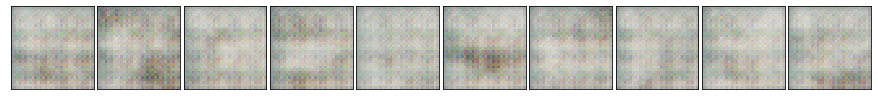

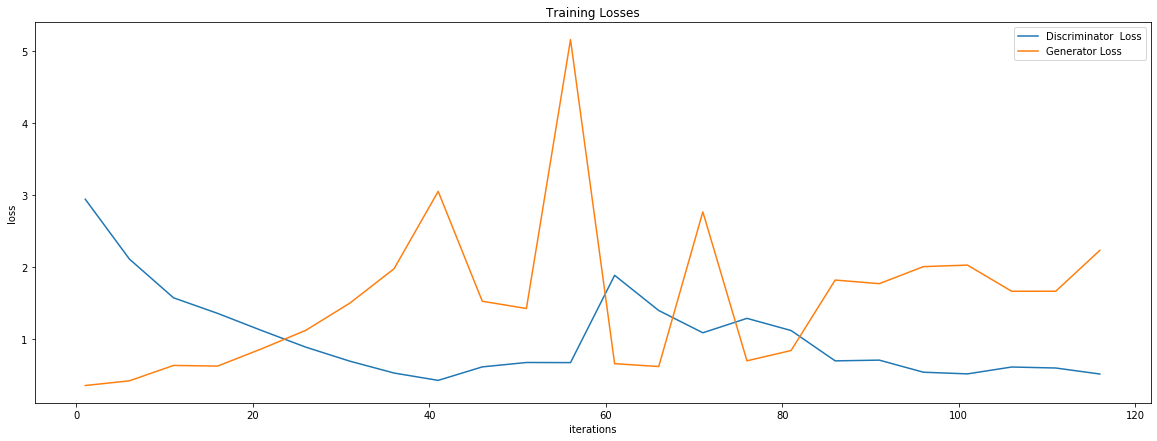

INFO:tensorflow:Restoring parameters from ./ckpt/generator.ckpt-120


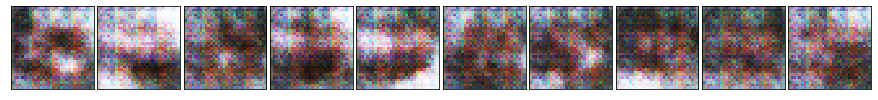

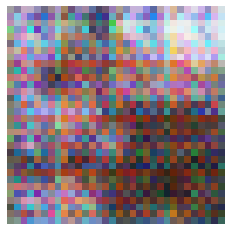

In [6]:
###############################################################################################################################################################
                     ############################################# tesing #####################################################
###############################################################################################################################################################

# show the final generating images
with open('./trainLog/GenLog.log', 'rb') as f:

    GenLog = pickle.load(f)
    GenLog = np.array(GenLog)
    ImgShow(GenLog,[-1],10)

# show the loss curve
with open(r'./trainLog/loss_variation.loss','rb') as l:
    losses = pickle.load(l)
    fig, ax = plt.subplots(figsize=(20, 7))
    plt.plot(losses.T[2],losses.T[0], label='Discriminator  Loss')
    plt.plot(losses.T[2],losses.T[1], label='Generator Loss')
    plt.title("Training Losses")
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

#save images
with tf.Session() as sess:

    meta_graph = tf.train.import_meta_graph('./ckpt/generator.ckpt-12000.meta')
    meta_graph.restore(sess,tf.train.latest_checkpoint('./ckpt'))
    graph = tf.get_default_graph()
    inputs_noise = graph.get_tensor_by_name("inputs_noise:0")
    d_outputs_fake = graph.get_tensor_by_name("generator/Tanh:0")

    sample_noise= np.random.normal(size=(10, 128))
    gen_samples = sess.run(d_outputs_fake,feed_dict={inputs_noise: sample_noise})
    gen_samples = [(gen_samples[0:11]+1)/2]
    ImgShow(gen_samples, [0], 10)
    for i in range(10):
        img=gen_samples[0][i]
        plt.imshow(img)
        plt.axis('off')
        plt.savefig("dcgan_img/car_%d.png" % i)
        plt.show
